- identify Document TOC Available or not.
- Rule(sorted largest text) + LLM based Document Title finder.

In [1]:
from logging import config
from marker.converters.pdf import PdfConverter
from marker.models import create_model_dict
# from marker.schema import BlockTypes

'''
- output_json: Whether to output the rendered document as JSON. By default, False.
- page_range: List of page numbers to process. By default, all pages are processed. eg. [0,1,5-6,...]
- ignore_TOC: Whether to ignore the page with Table of Contents page if detected. By default, False.
- use_llm: Whether to use LLM to enhance the parsing of the document. By default, False.
- ollama_base_url: Base URL for the Ollama LLM service. Default is 'http://localhost:11434'.
- llm_service: The LLM service class to use. Default is 'marker.services.ollama.OllamaService'.
- disable_ocr: Whether to disable OCR processing. By default, True, if the pdf/doc is not scanned, or in image formatable use OCR. OCR will make the process slow and detect empty spaces, output has no difference.
- renderer: The format of the output document can be one of the following ('markdown|pageMarkdown|chunks|pageMarkdown+chunks'). Default is 'pageMarkdown+chunks'.
    - for 'markdown', the output dict with keys 'markdown', Dict[str, str].
    - for 'pageMarkdown', the output dict with keys 'page_renders' containing 'page numbers' as keys and 'markdown' or 'html' as values, Dict[int, Dict[str, str]].
    - for 'chunks', the output dict with keys 'chunks'containing 'page_id' as keys and 'html' as values for the text, Dict[str, Dict[str, Any]].
    - for 'json', the output is standard StructuredJSON format for PDFs, Dict[str, Any].
    - for 'html', the output is standard HTML format for PDFs, Dict[str, Any].
    - for 'pageMarkdown+chunks', the output dict with keys 'page_renders' and 'chunks'.
    Output json format contains:
        - 'page_structure': List[Dict[str, Any]]  (List of page-wise structure with text and blocks)
        - 'page_renders'/'chunks' contain the information of the document.
'''

paths = [
    "C:\\Users\\Aditya Banerjee\\Documents\\Mobius\\Deployment\\Mobius-DocumentExtraction\\PDFs\\GNN.pdf",
    "C:\\Users\\Aditya Banerjee\\Documents\\Mobius\\Deployment\\Mobius-DocumentExtraction\\PDFs\\Graph_coherence.pdf"
]
pdfs = dict()

for p in paths:
    path = p
    converter = PdfConverter(
        artifact_dict = create_model_dict(),
        config = {
            # 'ollama_model': "llama3.2:latest",
            # "use_llm": True,
            # "ollama_base_url": "http://ollama-keda.mobiusdtaas.ai",
            # 'llm_service': 'marker.services.ollama.OllamaService',
            "page_range": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
            'disable_ocr': True,
            'output_json': True,
            "ignore_TOC": False,
            'ignore_before_TOC': True,
            "renderer": "chunks+pageMarkdown",
            "disable_tqdm": True,
        },
        processor_list=[]
    )
    document = converter.build_document(path)

    doc_render = converter.render_document(document)
    doc_render.pop('metadata')

    pdfs[path] = {
        'pdf_id': path.split('\\')[-1],
        'converter': converter,
        'doc_render': doc_render
    }


print("Completed PDF extraction for all files.")

`torch_dtype` is deprecated! Use `dtype` instead!
c:\Users\Aditya Banerjee\miniconda3\envs\docAgentRAG\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Aditya Banerjee\miniconda3\envs\docAgentRAG\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Completed PDF extraction for all files.


In [2]:
# # Install dependencies
# # Run this cell first to install required packages
# import subprocess
# import sys

# def install_packages():
#     packages = [
#         "langgraph",
#         "langchain-core",
#         "langchain-community",
#         "langchain-huggingface",
#         "langchain-openai",
#         "faiss-cpu",
#         "python-dotenv",
#         "sentence-transformers"
#     ]
#     for package in packages:
#         subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# install_packages()

In [2]:
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
from typing import (
    Annotated,
    Sequence,
    TypedDict,
)
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from typing import Type
from marker.schema.document import Document


In [9]:
from langchain_openai import ChatOpenAI
import os

llm = ChatOpenAI(model="gpt-4o-mini", api_key=os.getenv("OPENAI_API_KEY"))


In [10]:
# generate summary of document using first page
from langchain_core.messages import HumanMessage

def pdf_summarizer(doc_render: dict) -> str:
    '''
    Extract the abstract section from the PDF document.
    Args:
        pdf_filename (str): The path to the PDF file.
    Returns:
        str: The extracted abstract text.
    '''
    markdown = doc_render.get('page_renders', [])[0].get('markdown', '')
    prompt = HumanMessage(content=f"Following is the markdown of the first page of a research paper text. Summarize the content of the paper in not more than 200 words:\n\n{markdown}\n\n'")
    response = llm.invoke([prompt])
    return response.content.strip()

for path in paths:
    summary = pdf_summarizer(pdfs[path]['doc_render'])
    pdfs[path]['summary'] = summary
    print(f"Summary for {path}:\n{summary}\n")

Summary for C:\Users\Aditya Banerjee\Documents\Mobius\Deployment\Mobius-DocumentExtraction\PDFs\GNN.pdf:
This research paper provides a comprehensive review of Graph Neural Networks (GNNs), emphasizing their concepts, architectures, techniques, and applications. As deep learning continues to grow, GNNs have emerged as powerful tools for processing graph-structured data, which is critical for understanding relationships in diverse fields such as social networks, biology, and cybersecurity. The authors discuss various GNN models, including Graph Convolution Networks (GCNs), GraphSAGE, and Graph Attention Networks (GATs), highlighting their specific applications and functionalities. The paper also elaborates on the message-passing mechanism used by these models, detailing their strengths and weaknesses across different domains. It further explores common datasets utilized with GNNs, relevant Python libraries, and the overall landscape of GNN research. This review aims to guide future rese

In [11]:
from langchain_core.tools import tool
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from bs4 import BeautifulSoup
from langchain_text_splitters import RecursiveCharacterTextSplitter

def chunk_text(text, chunk_size=1000, chunk_overlap=100):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap
    )
    chunks = text_splitter.split_text(text)
    return chunks

def extract_chunks(doc_render: dict, chunk_size: int=500, chunk_overlap: int=50) -> list:
    plain_texts = []
    metadata = []
    for chunk in doc_render.get('chunks', {}).values():
        if (chunk.get('block_type') != 'Text'):
            continue
        html = chunk.get('html', '').strip()
        soup = BeautifulSoup(html, 'html.parser')
        plain_text = soup.get_text(separator=' ', strip=True)
        chunk_plain_texts = chunk_text(plain_text, chunk_size=chunk_size, chunk_overlap=chunk_overlap)
        for _plain_text in chunk_plain_texts:
            plain_texts.append(_plain_text)
            metadata.append({
                "id": f"/page/{chunk.get('page')}/{chunk.get('block_type')}/{chunk.get('block_id')}",
                "page": chunk.get('page')
            })
    return plain_texts, metadata

def find_chunk_by_id(chunk_id: str, doc_render: dict) -> str:
    for current_chunk_id, chunk in doc_render.get('chunks', {}).items():
        if current_chunk_id == chunk_id:
            html = chunk.get('html', '').strip()
            soup = BeautifulSoup(html, 'html.parser')
            plain_text = soup.get_text(separator=' ', strip=True)
            return plain_text
    raise ValueError(f"Chunk with id {chunk_id} not found.")

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# Build vector store from document chunks
for path in paths:
    doc_render = pdfs[path]['doc_render']
    chunks_text, metadata = extract_chunks(doc_render)
    vectorstore = FAISS.from_texts(chunks_text, embeddings, metadatas=metadata) if chunks_text else None
    pdfs[path]['vectorstore'] = vectorstore


In [38]:
# Define node functions
import json
import re
from langchain_core.messages import HumanMessage
import ast
import math
from langchain_classic.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_community.document_compressors import FlashrankRerank


def processor_pipeline(converter: Type[PdfConverter]) -> dict:
    for processor in converter.initialize_processors(converter.default_processors):
        processor(document)
    a = converter.render_document(document)
    a.pop('metadata')
    return a

def markdown_table_to_csv_json(md_text):
    # Extract the table section (from first "|" line to the last)
    table_block = []
    capture = False
    for line in md_text.splitlines():
        if line.strip().startswith("|"):
            capture = True
            table_block.append(line)
        elif capture:
            # Stop at first non-table line after capture
            break

    # Clean lines (remove markdown pipes formatting issues)
    clean_lines = [re.sub(r'\s*\|\s*$', '', line.strip()) for line in table_block]
    clean_lines = [line.strip("|") for line in clean_lines if line.strip()]

    # Split into rows
    rows = []
    for line in clean_lines:
        parts = [re.sub(r'<br>', ' ', cell).strip() for cell in line.split("|")]
        rows.append(parts)

    # Remove the separator line (---|---|---)
    header = rows[0]
    rows = [r for r in rows[1:] if not all(set(c.strip()) <= {"-", ""} for c in r)]

    return [header] + rows

def generate_multiple_queries(base_query: str, document_summary: str, n: int = 3) -> list:
    '''
    Generate multiple informative queries based on the base query.
    Args:
        base_query (str): The base user query.
        n (int): Number of queries to generate.
    Returns:
        list: List of generated queries.
    '''
    
    prompt = HumanMessage(content=f"Generate {n} different informative queries based on the following base query to retrieve relevant document context\n\nOutput format: \n[\n    \"query1\",\n    \"query2\",\n    \"query3\"\n]\n\nDocument summary: {document_summary}\n\nBase Query: {base_query}\n\nQueries:")
    response = llm.invoke([prompt])
    
    queries = ast.literal_eval(response.content)
    
    return queries[:n]

def get_path_from_pdf_id(pdf_id: str) -> str:
    pdf_filename = ""
    for path in paths:
        if pdfs[path]['pdf_id'] == pdf_id:
            pdf_filename = path
            break
    if not pdf_filename:
        return {'error': 'pdf_id not found.'}
    return pdf_filename

@tool
def extract_text(pdf_id: str, query: str) -> str:
    """
    Retrieve relevant document context based on the user query. Use informative query to generate better context. 
    Use the query to find relevant chunks of text from the PDF document.
    Args:
        pdf_id (str): The id of the PDF file.
        query (str): The user query.
    Returns:
        str: The retrieved document context.
    """
    
    pdf_filename = get_path_from_pdf_id(pdf_id)
    if 'error' in pdf_filename:
        return pdf_filename
    
    vectorstore = pdfs[pdf_filename]['vectorstore']
    chunk_set = set([])
    # queries = generate_multiple_queries(query, pdfs[pdf_filename]['summary'], n=3)
    if vectorstore:
        # Create reranker
        compressor = FlashrankRerank()
        compression_retriever = ContextualCompressionRetriever(
            base_compressor=compressor,
            base_retriever=vectorstore.as_retriever(search_kwargs={"k": 10})
        )
        for _query in [query]:
            docs = compression_retriever.invoke(_query)[:4]
            document = []
            for doc in docs:
                if doc.metadata.get('id') in chunk_set:
                    continue
                chunk_set.add(doc.metadata.get('id'))
                document.append(
                    json.dumps(
                        {
                            "page": doc.metadata.get('page'),
                            "Retrieved": find_chunk_by_id(doc.metadata.get('id'), doc_render)
                        }, 
                        indent=2
                    )
                )
    else:
        document = []
    
    return "\n\n".join(document)

@tool
def extract_tables(pdf_id: str, page_num: int = -1) -> list:
    '''
    Extract all tables from the rendered document for a specific page number.
    Args:
        pdf_id (str): The id of the PDF file.
        page_num (int, optional): The page number to extract tables from. Defaults to -1 (all pages).
    Output:
        list of extracted tables.
    '''
    
    pdf_filename = get_path_from_pdf_id(pdf_id)
    if 'error' in pdf_filename:
        return pdf_filename
    
    converter = pdfs[pdf_filename]['converter']
    doc_render = pdfs[pdf_filename]['doc_render']

    tables = []
    if not converter.processor_list:
        doc_render = processor_pipeline(converter)
    chunks = doc_render.get('chunks', {})
    
    for _, content in chunks.items():
        if content.get('page') != page_num:
            continue
        if content.get('block_type') != 'Table':
            continue
        tables.append({
                'page_number': content.get('page'),
                'table_data': markdown_table_to_csv_json(content.get('markdown', '')),
            })
    
    return json.dumps(tables)

@tool
def extract_pdf_abstract(pdf_id: str) -> str:
    '''
    Extract the abstract section from the PDF document.
    Args:
        pdf_id (str): The id of the PDF file.
    Returns:
        str: The extracted abstract text.
    '''
    
    pdf_filename = get_path_from_pdf_id(pdf_id)
    if 'error' in pdf_filename:
        return pdf_filename
    
    if pdfs[pdf_filename].get('abstract'):
        return pdfs[pdf_filename]['abstract']
    doc_render = pdfs[pdf_filename]['doc_render']
    markdown = doc_render.get('page_renders', [])[0].get('markdown', '')
    prompt = HumanMessage(content=f"Extract the abstract section from the following markdown text in not more than 200 words:\n\n{markdown}\n\nIf no abstract is found, respond with 'No abstract found.'")
    response = llm.invoke([prompt])
    pdfs[pdf_filename]['abstract'] = response.content.strip()

    return response.content.strip()

@tool
def extract_pdf_page(pdf_id: str, page_num: int) -> str:
    '''
    Extract the text at page `page_num` from the pdf with the given `pdf_id`. Only call if user specifically requests for a specific page content.
    Args:
        pdf_id (str): The id of the PDF file.
        page_num (int): The page number to extract the abstract from.
    Returns:
        str: The extracted abstract text.
    '''

    pdf_filename = get_path_from_pdf_id(pdf_id)
    if 'error' in pdf_filename:
        return pdf_filename
    
    doc_render = pdfs[pdf_filename]['doc_render']
    markdown = doc_render.get('page_renders', [])[page_num].get('markdown', '')
    return markdown

@tool
def ask_for_user_input(question: str) -> str:
    """
    Ask a question to the user to clarify any ambiguities.
    Args:
        question (str): The question to ask.
    Returns:
        str: The user's response.
    """
    return input(f"User Question: {question}\nYour Answer: ")

tools = [extract_text, extract_tables, extract_pdf_abstract, extract_pdf_page, ask_for_user_input]
agent = llm.bind_tools(tools)

In [43]:
import json
from langchain_core.messages import ToolMessage, SystemMessage
from langchain_core.runnables import RunnableConfig

tools_by_name = {tool.name: tool for tool in tools}
pdf_info = [
    {
        'pdf_id': pdfs[path]['pdf_id'],
        'summary': pdfs[path]['summary']
    }
    for path in paths
]


class AgentState(TypedDict):
    """The state of the agent."""
    # add_messages is a reducer
    # See https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers
    # pdfs: dict = pdfs
    messages: Annotated[Sequence[BaseMessage], add_messages]

# Define our tool node
def tool_node(state: AgentState):
    outputs = []
    for tool_call in state["messages"][-1].tool_calls:
        tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
        outputs.append(
            ToolMessage(
                content=json.dumps(tool_result),
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": outputs}

# Define the node that calls the model
def call_model(
    state: AgentState,
    config: RunnableConfig,
):
    # this is similar to customizing the create_react_agent with 'prompt' parameter, but is more flexible
    system_prompt = SystemMessage(
        "You are a helpful AI assistant working on helping users to understand information from PDF documents, please respond to the users query to the best of your ability!" \
        "Following is some information about the available PDF documents:\n\n" \
        f"{json.dumps(pdf_info, indent=2)}\n\n" \
        "Use the PDF information to identify the relevant document and answer the user's query." \
    )
    response = agent.invoke([system_prompt] + state["messages"], config)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

# Define the conditional edge that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"


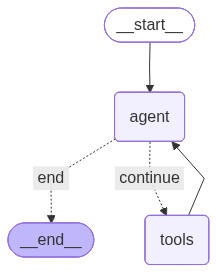

In [44]:
from langgraph.graph import StateGraph, END

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "tools",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("tools", "agent")

# Now we can compile and visualize our graph
graph = workflow.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


In [ ]:
# Helper function for formatting the stream nicely
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

inputs = {"messages": [("user", "Can you explain the methodology for implementing graph coherence from the paper it is present on page 3 and 4?")]}
print_stream(graph.stream(inputs, stream_mode="values"))


================================ Human Message =================================

Can you explain the methodology for implementing graph coherence from the paper it is present on page 3 and 4?
================================== Ai Message ==================================
Tool Calls:
  extract_pdf_page (call_3A2cqVkowH0Nn0AO5ZkGM23f)
 Call ID: call_3A2cqVkowH0Nn0AO5ZkGM23f
  Args:
    pdf_id: Graph_coherence.pdf
    page_num: 3
  extract_pdf_page (call_SlIv1hmYZzJdUEmUle5Vjc74)
 Call ID: call_SlIv1hmYZzJdUEmUle5Vjc74
  Args:
    pdf_id: Graph_coherence.pdf
    page_num: 4
================================= Tool Message =================================
Name: extract_pdf_page

"score of its permutation. In the insertion task, proposed by Elsner and Charniak (2011), we evaluate the ability of our system to retrieve the original position of a sentence previously removed from a document. For this, each sentence is removed in turn and a local coherence score is computed for every possible r